In [2]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import torch

### Compute statistics about inputs and targets

In [3]:
input_target_pairs = pd.read_json("/data/nicola/WSH/final_data/all_data.json", orient="records")
input_target_pairs.head(10)

,zone_id,maps_based_class,split,shape_area,species_key,species_count,species_based_class,num_classes
0,9,4,train,665918.930058,"[3032837, 3170807, 3105433, 2883073]",4,"[0, 0, 1, 1, 0, 1, 0, 0, 0]",3
1,10,4,train,2991.243434,[4299368],1,"[0, 0, 1, 1, 0, 1, 1, 1, 0]",5
2,13,6,train,230749.174683,[2891147],1,"[0, 0, 1, 1, 0, 1, 0, 0, 1]",4
3,26,4,train,400775.100939,"[5137582, 7799370]",2,"[0, 0, 1, 1, 1, 1, 0, 0, 0]",4
4,29,5,train,101384.855230,"[8207244, 5352367, 3170807]",3,"[0, 0, 1, 1, 0, 1, 0, 0, 0]",3
5,37,4,train,10094.769110,[5405976],1,"[0, 0, 1, 1, 1, 1, 0, 0, 1]",5
6,38,6,train,132550.544072,[5410886],1,"[0, 0, 1, 1, 1, 1, 0, 0, 1]",5
7,61,4,train,46156.868586,"[7270427, 8152305, 2482553, 5231240, 2494422]",5,"[0, 0, 1, 1, 0, 1, 0, 0, 0]",3
8,62,4,train,267678.647708,[5769191],1,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",1
9,65,4,train,91369.895171,[8207244],1,"[0, 0, 1, 1, 1, 1, 0, 0, 1]",5


In [4]:
len(input_target_pairs["species_based_class"][0])

9

In [5]:
input_target_pairs.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,zone_id,maps_based_class,shape_area,species_count,num_classes
count,25963.000000,25963.000000,2.596300e+04,25963.000000,25963.000000
mean,48656.067789,5.147864,1.386739e+05,3.762778,3.921427
std,27950.578900,1.902356,5.124324e+05,3.286255,1.478757
min,9.000000,1.000000,8.114492e+00,1.000000,0.000000
10%,10365.600000,3.000000,4.086319e+03,1.000000,2.000000
20%,21574.800000,4.000000,9.328835e+03,1.000000,3.000000
30%,26934.000000,4.000000,1.732712e+04,1.000000,3.000000
40%,36129.400000,4.000000,2.960359e+04,2.000000,3.000000
50%,49333.000000,5.000000,4.654735e+04,2.000000,4.000000
60%,59435.200000,6.000000,7.053005e+04,3.000000,4.000000


In [6]:
## Fraction of the area covered by the dataset
import geopandas as gpd
study_area = gpd.read_file("/data/nicola/WSH/raw_data/study_area/study_area.shp")
total_area = study_area.area[0]
dataset_area = input_target_pairs["shape_area"].sum()
dataset_area
difference = total_area-dataset_area
fraction = dataset_area/total_area
fraction
print(f"Precentage of zones covered with observations : {fraction:.2%}")

Precentage of zones covered with observations : 61.44%


/home/nicola/miniconda3/envs/pdm/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Text(0, 0.5, 'Number of occurences')

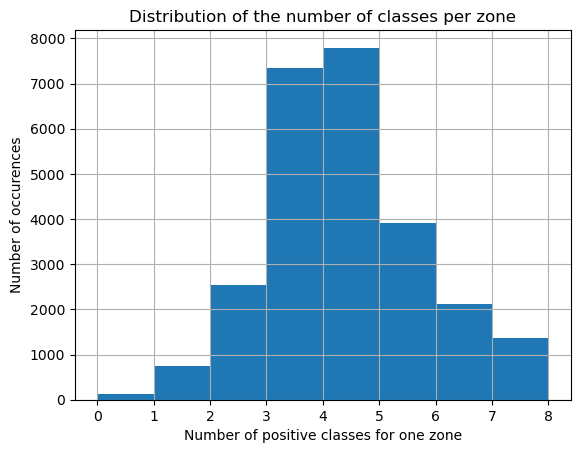

In [7]:
## Disribution of number of classes
plt.figure()
input_target_pairs["num_classes"].hist(bins=torch.arange(0,input_target_pairs["num_classes"].max()+1).tolist())
plt.title("Distribution of the number of classes per zone")
plt.xlabel("Number of positive classes for one zone")
plt.ylabel("Number of occurences")

In [8]:
torch.arange(0,input_target_pairs["num_classes"].max()+1).tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [9]:
## Relationship between number of species and number of classes
corr = input_target_pairs["species_count"].corr(input_target_pairs["num_classes"])
print(f"The correlation between the number of species and the number of classes for a given zone is : {corr:.2%}")

The correlation between the number of species and the number of classes for a given zone is : -60.88%


In [10]:
## Occurence rate of classes accross samples
import torch
contingency = torch.tensor(input_target_pairs["species_based_class"].tolist())
occurence_rates = pd.DataFrame()
occurence_rates["class"] = pd.read_json("/data/nicola/WSH/final_data/habitats_keys.json", orient="records")["class"]
occurence_rates["rate"] = contingency.sum(dim=0).div(contingency.size(0)).tolist()
pd.DataFrame(occurence_rates.set_index("class").describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

,rate
count,9.000000
mean,0.435714
std,0.371093
min,0.028849
10%,0.036922
20%,0.121719
30%,0.195347
40%,0.238655
50%,0.301236
60%,0.459646


In [11]:
occurence_rates.set_index("class")

,rate
class,
1,0.038940
2,0.028849
3,0.720564
4,0.973501
5,0.176906
6,0.959173
7,0.223010
8,0.499249
9,0.301236


In [12]:
## Splits relative size
input_target_pairs["split"].value_counts()

train    15504
test      7934
val       2525
Name: split, dtype: int64